# AI+分子模拟：从 Score Matching 到 Diffusion Model，从Swiss Roll到Butane（上）

<a href="https://bohrium.dp.tech/notebook/42989082bc7d44d09cd386d74be2ab83" target="_blank"><img src="https://cdn.dp.tech/bohrium/web/static/images/open-in-bohrium.svg" alt="Open In Bohrium"/></a>

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2024 @ Authors</i></b><br/>
        <i>作者：<b> <a href="mailto:cxwang@stu.xmu.edu.cn">王程玄 📨 </a> <a href="mailto:wangxy@dp.tech">王新颜 📨 </a> <a href="mailto:zhanglf@dp.tech">张林峰 📨 </a> <br/>
        <i>日期：2024-03-12</i><br/>
        <i>共享协议：</a>本作品采用<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议</a>进行许可。</i>
    </p>
</div>

## 背景介绍 
Diffusion Model是基于随机过程的生成模型，在过去几年中，由于其图像生成领域的优秀表现，使其成为广泛瞩目的生成模型之一。此类模型以物理学中的扩散过程为灵感，模仿如何通过逐渐加入噪声将数据样本转化为高斯噪声，并在采样过程中逐渐去除这些噪声以生成新的数据样本。
<img src="https://pan.axuan.wang/diffusion.png">

Diffusion Model在图像合成、声音生成乃至分子场景创建等多个领域展示了卓越的性能，因其独特的生成方式在数据生成领域，尤其是在生成复杂数据分布方面成为一个重要研究方向。 

与此同时，Diffusion model和物理化学过程有着相似的思想方式，对于我们关注的在势能面上的采样过程而言，即类似于在diffusion model生成的分布模型上进行采样的过程，其中scoring matching的方法即通过神经网络（暴力的函数拟合器）的方法对实际的概率分布中的梯度进行拟合，进而做到对概率分布的描述。类似的相似关系在Al4S和生成模型的关系中也常常可以看到，如中科院物理所王磊教授在深势科技的一个[报告](https://wangleiphy.github.io/lectures/GenerativeAI-DP.pdf)。这里将其中两页PPT截图分享如下，阐释了生成模型中的变量和物理化学中的变量关系：

<img src="https://pan.axuan.wang/genphys.png">

**在本notebook当中，我们首先结合一个简单的的二维分布，对scoring matching以及diffusion model的原理进行初步的认识和实现。**

---

## 目录

## * [提前准备：Dataset and Notation](#layer0)
## * [Score Matching: 一切由此出发](#layer1)
## * [NeuralODE, flow matching, and Rectified flow](#layer2)
## * [说回到consistency models](#layer3)
## * [这与AI for Science有什么关系](#layer4)

##  阅读本文可能需要30分钟以上，边运行边消化可能需要**1-2小时**。

## 考虑到读者的时间通常比较碎片化，以下总结出本文要点（篇幅所限较为简略，缩写大多在正文中会被解释）：

## 1. **技术路径**：对Consistency Model 来说，有一条相对清晰的技术演化路径，从score matching，到跟SDE和非平衡热物理更相关的Diffusion Model等，以及跟ODE更相关的NeuralODE和flow matching等；
## 2. **理论算法**：Probability Flow (PF) ODE是SDE和ODE的一个桥梁（进而是Consistency Model被蒸馏训练的基础）
$$
\text{d}{\bf{x}}_t={\bf{\mu}}({\bf{x}}_t,t)\text{d}t+\sigma(t)\text{d}{\bf{w}}_t
\leftrightarrow
\text{d}{\bf{x}}_t=\left[{\bf{\mu}}({\bf{x}}_t,t)-\frac{1}{2}\sigma(t)^2\nabla\log p_t({\bf{x}}_t)\right]\text{d}t
$$
3. **技术细节**：尽管我们会看到很多formulation（model arch./loss function/training scheme等)之间的等价性，但实际效果可能会千差万别。在本系列代码中，我们会看到，哪怕是一个二维的简单例子，对于很多算法来说。也需要很多微妙的细节处理，例如噪音大小、时间步长策略、采样策略等。这些细节也体现在了consistency models的很多“迷之操作”中。
4. **行业影响**：这可能对AIGC有啥影响呢？简单来说，如果效果真的好，基本就是能更快、更低成本、更大规模地出图（当然，这里有待验证）。
5. **这跟AI for Science（AI4S）又有什么关系呢？** 这是本文作者最最兴奋的地方。卖个关子，没时间跑代码的同学，也欢迎你划过去看一看。那里也会讨论“consistency model”是否意味着扩散模型的终结。

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-top:1rem; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        📖 <b>上手指南</b><br/>
        本文档可在 <a style="font-weight:bold; color:purple" href="https://bohrium-doc.dp.tech/docs/userguide/Notebook" target="_blank"> Bohrium Notebook</a> 上直接运行。你可以点击界面上方按钮 <span style="background-color:darkblue; color:white; padding: 1px; border-radius: 5px;">开始连接</span>，选择 <u>bohrium-notebook</u> 推荐镜像。由于涉及到少量机器学习训练任务，推荐使用任意GPU节点配置，稍等片刻即可运行。
    </p>
</div>

# 提前准备：Dataset and Notation <a id='layer0'></a>

## 关于数据集
## 我们使用sklearn中的swiss_roll标准数据集，这是个二维点的分布。

## 其好处在于计算复杂度低，但同时也要注意的是，当维数升高的时候，模型的表示、优化手段的设计（损失函数的选择等）、相应问题的结构（例如对称性等）也都将扮演更加重要的角色。

## Swiss Roll的分布如下：

In [1]:
! pip install matplotlib scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.3 MB/s eta 0:00:00a 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 330.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 2.3 MB/s eta 0:00:00a 0:00:01


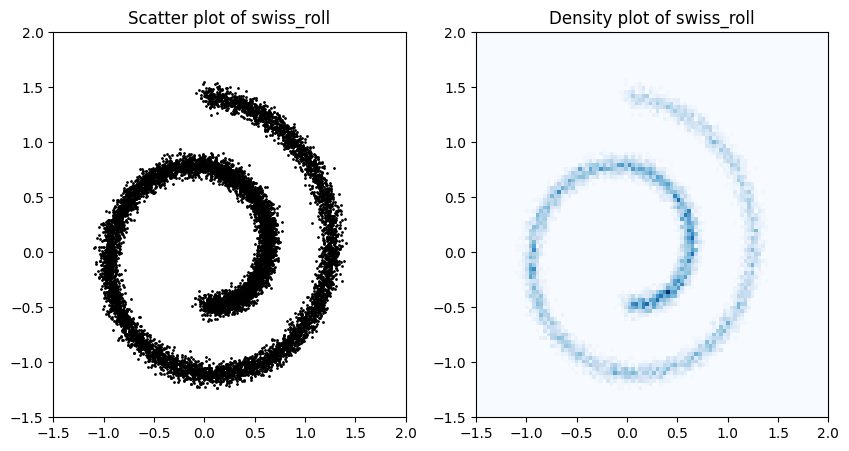

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
# 从数据中采样特定batch size的样本
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
# Plot it
data = sample_batch(10**4)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axes[0].set_title('Scatter plot of swiss_roll')
axes[0].plot(data[:,0], data[:,1],'ko',markersize=1)
axes[0].set_xlim([-1.5,2])
axes[0].set_ylim([-1.5,2])
axes[1].set_title('Density plot of swiss_roll')
axes[1].hist2d(data[:,0], data[:,1],bins=100, cmap='Blues',range=np.array([(-1.5, 2.0), (-1.5, 2.0)]))
axes[1].set_xlim([-1.5,2])
axes[1].set_ylim([-1.5,2])
plt.show()

### 关于Notation

我们将尽量follow下面的Notation：

用$q(\mathbf{x})$表示数据的真实分布; $q_0(\mathbf{x})=\frac{1}{n}\sum_{i=1}^n\delta(||\mathbf{x}-\mathbf{x}^{(i)}||)$ 表示数据的经验分布；
  $q_\sigma(\tilde{\mathbf{x}}|\mathbf{x})=\frac{1}{(2\pi)^{d/2}\sigma^d}e^{-\frac{1}{2\sigma^2}||\tilde{\mathbf{x}}-\mathbf{x}||^2}$表示用来给每个数据点做光滑化的Gaussian Kernel。
  
  进一步，$q_\sigma(\tilde{\mathbf{x}},\mathbf{x})=q_0(\mathbf{x})q_\sigma(\tilde{\mathbf{x}}|\mathbf{x})$表示$\tilde{\mathbf{x}}$与$\mathbf{x}$的联合分布，对其中$\mathbf{x}$进行积分，可得到所谓Parzen density，$q_\sigma(\tilde{\mathbf{x}})=\frac{1}{n}\sum_{i=1}^nq_\sigma(\tilde{\mathbf{x}},\mathbf{x}^{(i)})$

# Score Matching: 一切由此出发 <a id='layer1'></a>

我们考虑的“AIGC”任务是利用机器学习模型学一个数据分布，并通过学到的分布来生成更多样本。一类完成这类任务的方法是利用密度估计。

考虑参数为$\theta$的分布$p(\mathbf{x},\theta)=\frac{e^{-E(\mathbf{x},\theta)}}{Z(\theta)}$。这里$E(\mathbf{x},\theta)$被称为能量，$Z(\theta)=\int e^{-E(\mathbf{x},\theta)}d\mathbf{x}$被称为配分函数。

我们可以想象的是，准确表示$E(\mathbf{x},\theta)$并求出$Z(\theta)$是一件困难的事情。因此，人们考虑用**score函数** $\psi(\mathbf{x};\theta)$来表示$E(\mathbf{x},\theta)$对输入$\mathbf{x}$的导数：
$$\psi(\mathbf{x};\theta)=\frac{\partial \log p(\mathbf{x},\theta)}{\partial \mathbf{x}}$$
这里由于$Z(\theta)$不依赖于$\mathbf{x}$，省去了对求出$Z(\theta)$的需求。

学习score函数的方法被称为score matching，我们也将在后面的部分介绍如何从学到的score出发生成新的分布。

### Explicit Score Matching (ESM)

Score该怎么学？一个最直观的损失函数是Explicit Score Matching (ESM)损失函数：
$$ \mathcal{L}_{ESMq}(\theta)= E_{\mathbf{x} \sim q(\mathbf{x})} \left[ \frac{1}{2}\left\Vert \psi(\mathbf{x};\theta) -\frac{\partial \log q(\mathbf{x})}{\partial \mathbf{x}} \right\lVert^2 \right]
, $$
这个损失函数看起来自然，但不具有可操作性。原因是$q(\mathbf{x})$未知，那么$\frac{\partial \log q(\mathbf{x})}{\partial \mathbf{x}}$自然也无法评估。

### Implicit Score Matching (ISM)
由于ESM存在的问题，早在[2005年](https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf)，Hyvärinen 便提出了所谓Implicit Score Matching (ISM)的方式：

$$ \mathcal{L}_{ISMq} = E_{\mathbf{x} \sim q(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \psi(\mathbf{x};\theta) \right) + \frac{1}{2} \left\Vert \psi(\mathbf{x};\theta) \right\lVert_2^2 \right]
, $$

不难得出，在对数据分布的合理假设要求下，$\mathcal{L}_{ISMq}$与$\mathcal{L}_{ESMq}$之间只差一个与参数$\theta$无关的常数。（具体的证明需要展开$\mathcal{L}_{ESMq}(\theta)$的表达式，考虑其中$\theta$相关的项，并进行分部积分。）


进而，从数据的经验分布出发，对$\mathcal{L}_{ISMq}$的优化可以进一步转化为对$\mathcal{L}_{ISMq_0}$的优化，而后者是完全可操作的。
$$ \mathcal{L}_{ISMq_0} = E_{\mathbf{x} \sim q_0(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \psi(\mathbf{x};\theta) \right) + \frac{1}{2} \left\Vert \psi(\mathbf{x};\theta) \right\lVert_2^2 \right]
=\frac{1}{n}\sum_{i=1}^n \left( \text{ tr}\left( \nabla_{\mathbf{x}}  \psi(\mathbf{x}^{(i)};\theta) \right) + \frac{1}{2} \left\Vert \psi(\mathbf{x}^{(i)};\theta) \right\lVert_2^2 \right)$$

下面，我们通过Swiss Roll数据集来说明这点。

首先，我们用一个神经网络模型来表示$\psi(\mathbf{x};\theta)$.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
model_psi = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)

optimizer = optim.Adam(model_psi.parameters(), lr=3e-3)

注意这里我们没有用一个能量对输入的导数来表示$\psi(\mathbf{x};\theta)$，而是用了一个有两个输出的函数。这有可能会使得$\psi(\mathbf{x};\theta)$不是一个梯度场。

接下来，我们将需要通过如下函数求出雅可比项（Jacobian）$\text{ tr}\left( \nabla_{\mathbf{x}}  \psi(\mathbf{x};\theta) \right)$

In [4]:
import torch.autograd as autograd

def jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian

更近一步，我们可以定义ISM的损失函数：

In [5]:
def ism_loss(model, samples, train=False):
    samples.requires_grad_(True)
    logp = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(logp, dim=-1) ** 2 / 2.
    # Compute the Jacobian loss
    jacob_mat = jacobian(model, samples)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
    return (tr_jacobian_loss + norm_loss).mean(-1)

接下来就可以训练了！

In [6]:
l_curve = []
print('[Training step, loss value]')
for training_step in range(5000):
    dataset = torch.tensor(sample_batch(3*10**2)).float()
    # Compute the loss.
    loss = ism_loss(model_psi, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((training_step % 10) == 0):
        l_curve.append([training_step, loss.item()])
    if ((training_step % 500) == 0):
        print([training_step, loss.item()])

[Training step, loss value]
[0, 0.1868923008441925]
[500, -60.2452278137207]
[1000, -110.15348815917969]
[1500, -112.88984680175781]
[2000, -134.59991455078125]
[2500, -112.07180786132812]
[3000, -152.19956970214844]
[3500, -150.8235626220703]
[4000, -165.9660186767578]
[4500, -175.6434783935547]


画出损失函数随着训练步数的变化，可以看出在一段简短的平滑期后，损失函数会迅速下降，并最终收敛至-160左右。

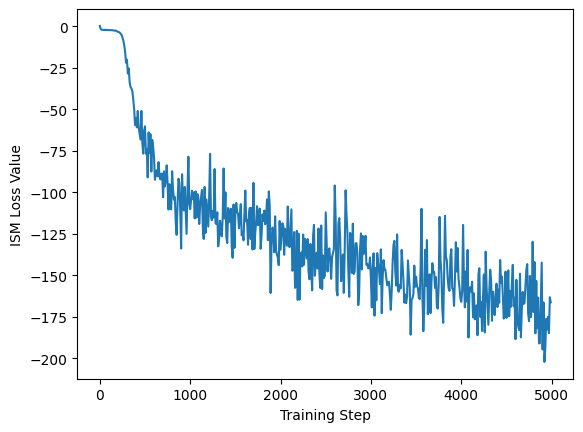

In [7]:
l_curve_ism = np.array(l_curve)
plt.plot(l_curve_ism[:,0],l_curve_ism[:,1])
plt.xlabel('Training Step')
plt.ylabel('ISM Loss Value')
plt.show()

下面，我们可以画出$\psi(\mathbf{x};\theta)$这一矢量场在$\mathbf{x}$不同取值时的方向和幅度。

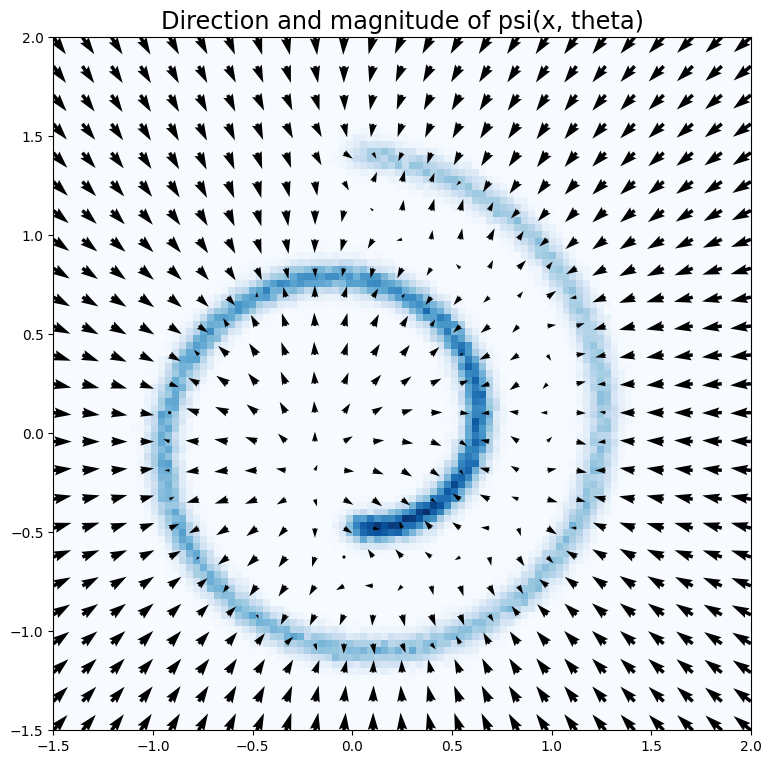

In [8]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 25), np.linspace(-1.5, 2.0, 25)), axis=-1).reshape(-1, 2)
    scores = model(torch.tensor(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(9,9))
    plt.hist2d(data[:,0], data[:,1],bins=100,cmap='Blues',range=np.array([(-1.5, 2.0), (-1.5, 2.0)]))
    plt.quiver(*xx.T, *scores_log1p.T, width=0.005, color='black')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
    plt.title('Direction and magnitude of psi(x, theta)',fontsize='xx-large')
    plt.show()
plot_gradients(model_psi, sample_batch(10**5))

### Langevin dynamics

单从梯度场的指向可能很难推断实际效果。接下来，我们可以根据在分子动力学课程上学到的内容，通过(这里是over-damped) Langevin dynamics等方式来实现$p(\mathbf{x},\theta)=\frac{e^{-E(\mathbf{x},\theta)}}{Z(\theta)}$密度分布下的采样：
$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \frac{\epsilon}{2} \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t,\theta) + \sqrt{\epsilon} \mathbf{z}_{t}$$
这里$\mathbf{z}_{t}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$。我们知道，从一个合理的初始分布出发，当$\epsilon \rightarrow 0, t \rightarrow \inf$的时候，$\mathbf{x}_t$的分布收敛至$p(\mathbf{x},\theta)$。

这里我们从 $\mathbf{x}_{0} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$出发，通过逐步减小$\epsilon \rightarrow 0$ 来得到 $p(\mathbf{x},\theta)$。以下为一种实现。

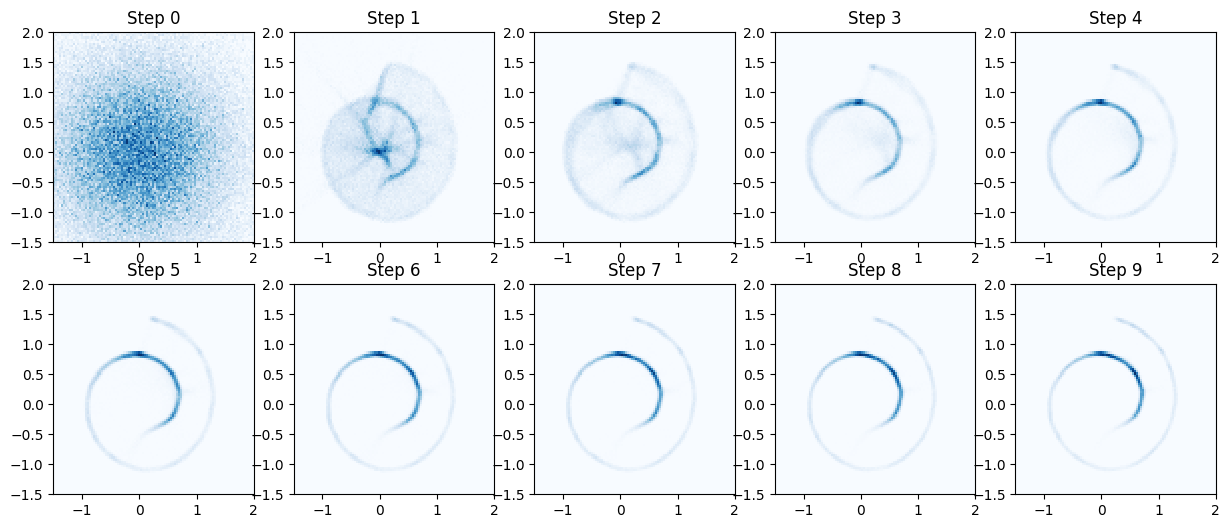

In [9]:
n_steps=9
eps=1e-2
decay=.9
temperature=1.0

xx =  torch.normal(0, 1, size=(10**5,2))
xx_t = []
xx_t.append(xx.detach().numpy())

for ii in range(n_steps):
    z_t = torch.rand(xx.size())
    xx = xx + (eps / 2) * model_psi(xx) + (np.sqrt(eps) * temperature * z_t)
    eps *= decay
    xx_t.append(xx.detach().numpy())
xx_t = np.array(xx_t)

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues',range=np.array([(-1.5, 2.0), (-1.5, 2.0)]))
    axes[ii_x,ii_y].set_xlim([-1.5,2])
    axes[ii_x,ii_y].set_ylim([-1.5,2])
plt.show()

**小结：** 结合这个表达式以及上面的运行结果，我们可以畅想一下diffusion model在分子动力学模拟当中的应用场景。如果我们能够建立一个相对完善的势函数，那么对于任何的$\mathbf{x}_0$，我们都能找到对应的完整的势能面。相较于传统的分子动力学采样过程成本会随之降低，并能提高计算的效率。同时也能更容易的跨过较高的能垒，进而简化在传统的采样过程中的增强采样过程。

### Sliced score matching（SSM）

上述ISM的方法尽管相对直观，但是很难推广至高维。其原因在于，计算$\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right)$对应的雅可比矩阵计算的复杂度是$O(N^2 + N)$。

为此，**本文讨论的consistency model的一作同学** Yang Song等人提出了[Sliced score matching](https://arxiv.org/pdf/1905.07088.pdf)的方法，将ISM的优化问题转化为优化
$$ \mathcal{L}_{SSMq}(\theta) = E_{\mathbf{v} \sim \mathcal{N}(0, 1)} E_{\mathbf{x} \sim q(\mathbf{x})} \left[ \mathbf{v}^T \nabla_{\mathbf{x}} \psi(\mathbf{x};\theta) \mathbf{v} + \frac{1}{2} \left\Vert \mathbf{v}^T\psi(\mathbf{x};\theta) \right\lVert_2^2 \right]
, $$
其中$\mathbf{v} \sim \mathcal{N}(0, 1)$表示一组高维随机向量。这可以通过前向自动微分得到，进而有较高的效率。

在此我们不对SSM做展开，而是直接进入下一个与后面的方法关联性更大的部分，Denoising score matching。

### Denoising score matching (DSM)

接下来介绍一篇非常经典的文章，
[Vincent, P. (2011). A connection between score matching and denoising autoencoders. Neural computation, 23(7), 1661-1674.](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf)。

该文章在讨论denoising autoencoders的过程中，介绍了一个比较适合推广至高维做优化的损失函数。首先，考虑对输入$\mathbf{x}$的一个边缘分布$q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})$。以下损失函数
$$ \mathcal{L}_{DSMq}(\theta)= E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim q(\mathbf{x})} \left[ \left\Vert \psi(\tilde{\mathbf{x}};\theta) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) \right\lVert_2^2 \right]
, $$
在$q_{\sigma}(\mathbf{x}) \approx q(\mathbf{x})$的条件下也可以用来优化$\psi(\mathbf{x};\theta)$。

进一步，令 $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})=\mathcal{N}(\tilde{\mathbf{x}}\mid\mathbf{x}, \sigma^{2}\mathbf{I})$，则有 $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) = \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}}$。

这里我们需要令$\sigma$足够小。直觉上来看，这里在做的事情事实上就是在$\mathbf{x}$附近产生幅度为$\frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}}$的偏离噪音时，利用$\psi(\mathbf{x};\theta)$来修正这一噪音。


如下我们实现DSM Loss，并做相应的优化。

在这个优化的过程当中，$\sigma$的选择要慎重。。。太大了近似不成立，太小了噪音可能太大。

下面做了一个非常简单的改动后（let $\sigma=0.1$, instead of 0.01），会得到比较好的效果。

In [10]:
def dsm_loss(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

In [11]:
model_psi = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)

optimizer = optim.Adam(model_psi.parameters(), lr=3e-3)

l_curve = []
print('[Training step, loss value]')
for t in range(5000):
    dataset = torch.tensor(sample_batch(10**4)).float() #LF：这里的sample数需要的非常大
    # Compute the loss.
    loss = dsm_loss(model_psi, dataset, sigma=0.1)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((t % 20) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 500) == 0):
        print([t,loss.item()])

[Training step, loss value]
[0, 100.5608139038086]
[500, 81.25548553466797]
[1000, 68.4693374633789]
[1500, 64.5993881225586]
[2000, 64.75675964355469]
[2500, 63.39436721801758]
[3000, 65.86219024658203]
[3500, 62.052799224853516]
[4000, 63.11859893798828]
[4500, 62.59592056274414]


**值得注意的是，这里的噪音并没有下降。** 如下图所示。当然，这也是可以预期的，因为DSM的损失函数本身是带有较大的噪音项的。

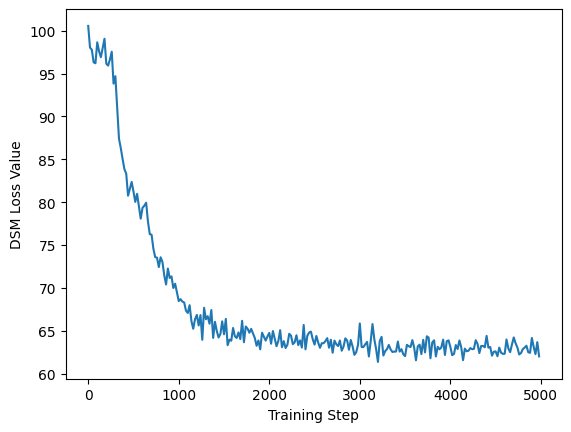

In [12]:
l_curve_dsm = np.array(l_curve)
plt.plot(l_curve_dsm[:,0],l_curve_dsm[:,1])
plt.xlabel('Training Step')
plt.ylabel('DSM Loss Value')
plt.show()

那么，学到的score 做langevin dynamics的结果如何呢？

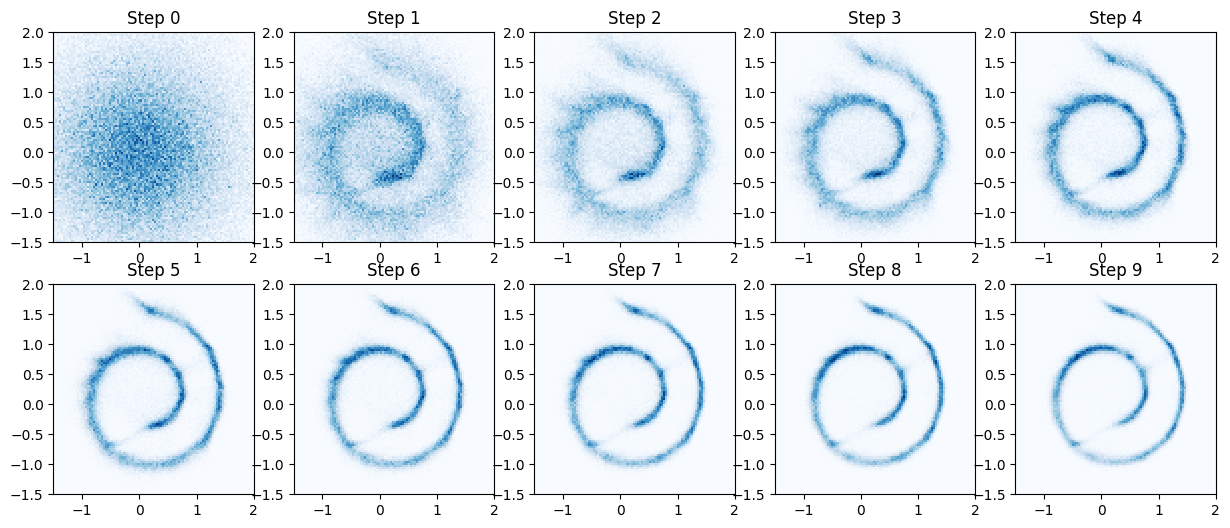

In [13]:
n_steps=9
eps=1e-2
decay=.9
temperature=1.0

xx =  torch.normal(0, 1, size=(10**5,2))
xx_t = []
xx_t.append(xx.detach().numpy())

for ii in range(n_steps):
    z_t = torch.rand(xx.size())
    xx = xx + (eps / 2) * model_psi(xx) + (np.sqrt(eps) * temperature * z_t)
    eps *= decay
    xx_t.append(xx.detach().numpy())
xx_t = np.array(xx_t)

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues',range=np.array([(-1.5, 2.0), (-1.5, 2.0)]))
    axes[ii_x,ii_y].set_xlim([-1.5,2])
    axes[ii_x,ii_y].set_ylim([-1.5,2])
plt.show()

**值得注意的是**，这里其实涉及到一个权衡取舍。$\sigma$过小的时候训练噪音大、$\sigma$过大的时候难以保障数值近似的要求——我们后面会看到，在分子动力学的一些地方也有着类似的现象。感兴趣的读者不妨尝试，如果令$\sigma=0.3$或者$0.5$，效果也挺差的。。

### 总结

我们再来看一下以下几个损失函数。它们在原则上（不考虑实际的统计收敛性、计算复杂度、模型表示能力和优化效率）均能给出理想的矢量场。

$$ \mathcal{L}_{ESMq}(\theta)= E_{\mathbf{x} \sim q(\mathbf{x})} \left[ \frac{1}{2}\left\Vert \psi(\mathbf{x};\theta) -\frac{\partial \log q(\mathbf{x})}{\partial \mathbf{x}} \right\lVert^2 \right]
, $$
$$ \mathcal{L}_{ISMq} = E_{\mathbf{x} \sim q(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \psi(\mathbf{x};\theta) \right) + \frac{1}{2} \left\Vert \psi(\mathbf{x};\theta) \right\lVert_2^2 \right]
, $$
$$ \mathcal{L}_{SSMq}(\theta) = E_{\mathbf{v} \sim \mathcal{N}(0, 1)} E_{\mathbf{x} \sim q(\mathbf{x})} \left[ \mathbf{v}^T \nabla_{\mathbf{x}} \psi(\mathbf{x};\theta) \mathbf{v} + \frac{1}{2} \left\Vert \mathbf{v}^T\psi(\mathbf{x};\theta) \right\lVert_2^2 \right]
, $$
$$ \mathcal{L}_{DSMq}(\theta)= E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim q(\mathbf{x})} \left[ \left\Vert \psi(\tilde{\mathbf{x}};\theta) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) \right\lVert_2^2 \right]$$

但是，ESM是不直接可用的；ISM效果很好、但因为对Jacobian的需求，面临维数灾难；SSM和DSM看起来没有直接的维数灾难，但当数据维数变高时，直接使用它们也带来了一些进一步的挑战——既包括学习分布（或者score）的挑战、也包括学好score后生成样本带来的挑战。例如，在学好数据里的能量函数后需要用本文所介绍的Langevin Dynamics做采样。熟悉分子模拟的同学会清楚，如果相应的energy landscape比较崎岖、或者有能量或熵带来的能垒，那么这样的dynamics就会受到rare event的影响。这在数据科学中也是可以预期的（这也与mode collapse这一问题有很强的相关性）。

最后，值得一提的是，如果你能掌握推导这些损失函数相互等价性所需要的技巧，那么推导diffusion model、consistency model等对应的算法原理也不成问题。因为score matching所对应的原理和技巧恰好也是后续算法发展的基础。

## Scoring Matching遇到的问题
在笔者理解上述的数学过程以及代码实现的过程当中，尝试了一些其他数据集在scoring matching方法中的实现。偶然间发现，scoring matching对于对称性较高的数据集的表现效果明显不如上面的Swiss roll数据集。下面我们将通过一个简单的同心圆模型来说明这个问题。在这个圆的周长上，散点以高斯函数分布，使得整个空间中的函数可导，符合scoring matching的要求。

同时如上所述，scoring matching对空间中不连续可导的分布情况无法做到很好的预测，相较于对称性，在以前尝试的数据集当中遇到的问题更多可能集中于此。

定义两个同心圆，半径分别为1和2.此处采用极坐标的方式建模，由于要求的是在面积上均匀分布，因此半径需要平方再开方以达到在指定面积上均匀采样的目的。

In [14]:
def std_circle(shape):
    x = np.array([])
    y = np.array([])
    for i in range(4):
        # r = np.random.uniform(1,i+1,int(shape/4))**0.5
        r = np.random.normal(1.5**2, 0.3, int(shape/4))**0.5
        theta = np.random.uniform(i*0.5*np.pi,(i+1)*0.5*np.pi, int(shape/4))
        z = np.random.random(shape)
    
        x = np.append(x, r*np.cos(theta))
        y = np.append(y, r*np.sin(theta))
    # return np.append(np.append(x,y), z).reshape(3, shape).T
    return np.append(x,y).reshape(2, shape).T
    # return np.sqrt(x**2+y**2).reshape(1, shape).T

生成样本数据，并可视化样本数据图形分布。

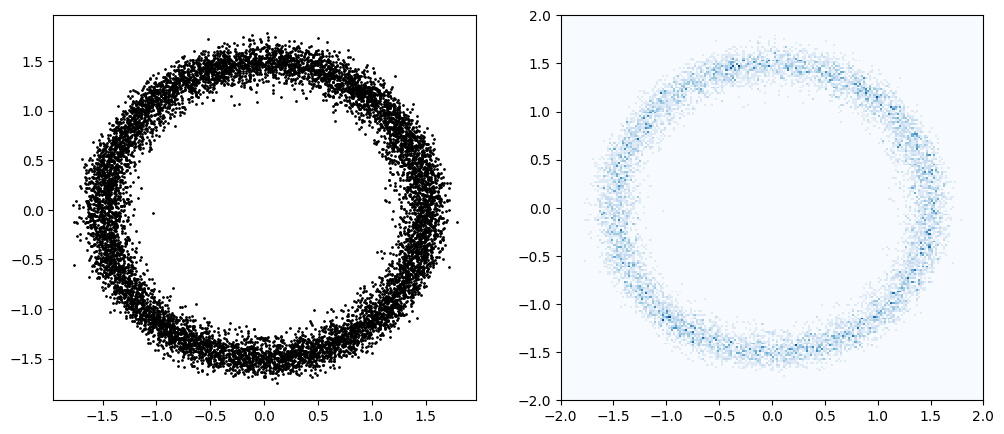

In [15]:
# sample = np.append(swiss_roll(10**4), std_circle(10**4)).reshape(-1,2)
sample = std_circle(10**4)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
axes[0].plot(sample[:,0], sample[:,1],'ko',markersize=1)
axes[1].hist2d(sample[:,0], sample[:,1],bins=200,cmap='Blues',range=np.array([(-2, 2), (-2, 2)]))
plt.show()

定义神经网络并训练。

In [20]:
model_psi = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)

model_psi.cuda()
optimizer = optim.Adam(model_psi.parameters(), lr=3e-3)

l_curve = []
print('[Training step, loss value]')
for t in range(5000):
    dataset = torch.tensor(sample)[torch.randint(0,sample.shape[0], (int(3*10**3),))].float()
    dataset = dataset.cuda()
    # Compute the loss.
    loss = ism_loss(model_psi, dataset) 
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((t % 20) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 1000) == 0):
        print([t,loss.item()])

[Training step, loss value]
[0, 0.31529828906059265]
[1000, -50.432655334472656]
[2000, -52.342926025390625]
[3000, -53.0850944519043]
[4000, -52.825721740722656]


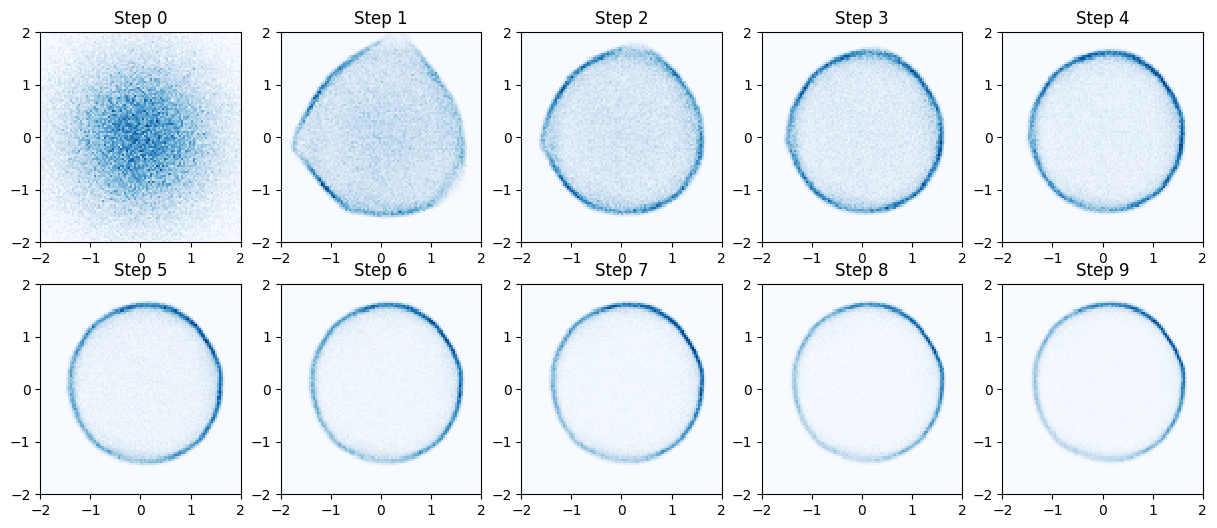

In [21]:
n_steps=9
eps=torch.tensor(1e-2).cuda()
decay=torch.tensor(.9).cuda()
temperature=torch.tensor(1.0).cuda()

xx = torch.normal(0, 1, size=(10**5, 2))
xx_t = []
xx_t.append(xx.detach().numpy())
xx = xx.cuda()

for ii in range(n_steps):
    z_t = torch.rand(xx.size()).cuda()
    xx = xx + (eps / 2) * model_psi(xx) + (torch.sqrt(eps) * temperature * z_t)
    eps *= decay
    xx_t.append(xx.detach().cpu().numpy())
xx_t = np.array(xx_t)

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    # axes[ii_x,ii_y].hist(xx_t[ii,:,0],bins=100, range=np.array([-2, 2.0]))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues',range=np.array([(-2, 2.0), (-2, 2.0)]))
    axes[ii_x,ii_y].set_xlim([-2,2])
    axes[ii_x,ii_y].set_ylim([-2,2])
plt.show()

**小结:** 从上面的结果中可以看出，对于该对称性较高的体系，scoring matching的效果只能说是差强人意。

在后面的尝试当中，笔者尝试将坐标$[x,y]$的输入改为距离$r$的输入，并在应用时逐步更新每个点的距离，再逐步输入。呈现的效果类似于落入局部最小值的情况（在圆的某一段周长上表现的比较好），尝试增大learning rate的值，效果稍微改善但也没有出现很好的结果。出现这样的原因需要进一步的问题探索。

# Diffusion model的正向加噪和反向去噪过程
$$
\text{forward (diffusion)} : q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$
$$
\text{reverse (parametric)} : p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})
$$
**简述：**Diffusion model可以理解为将原本的样本分布使用Markov过程不断的加入噪音，然后使用神经网络的这一工具作为去除噪音的函数，并构造相关的损失函数进行训练。此处构造损失函数的方式可以使用加噪之前的训练集作为label样本，使用`model`神经网络预测出的结果作为函数值，同时使用均方根误差作为损失函数（**hint:** 类似于scoring matching中的ESM构建方式）。但是聪明的数学家显然不想使用这样简单粗暴的方法，结合加噪过程的实现，将这个过程中的每个转变都简单地定义为条件高斯。 因此，在学习过程中，只需要训练高斯扩散核的均值和协方差，并能构建出更为多样可控的损失函数。


## 正向加噪过程的实现
正向加噪过程可以理解为一个累积的马尔科夫过程，在实际的实现过程中，我们使用逐渐加入高斯噪声的手段，则对应的$q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$为：
$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

其中$q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$意为在给定时间$t-1$时刻的状态$\mathbf{x}_{t-1}$的条件下，时间$t$时刻状态$\mathbf{x}_t$的概率分布。则对于最终的时刻$T$其分布和初始状态下的分布的关系如下：

$$
q(\mathbf{x}_{0:T}) =  q(\mathbf{x}_{0}) \prod_{t=1}^{T} q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$

对加噪比例$\beta$进行实现，并计算与之对应的$\alpha$，同时计算和该两者相关的诸多常数

In [22]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

n_steps = 100

betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2).cuda()
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float().cuda(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [23]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

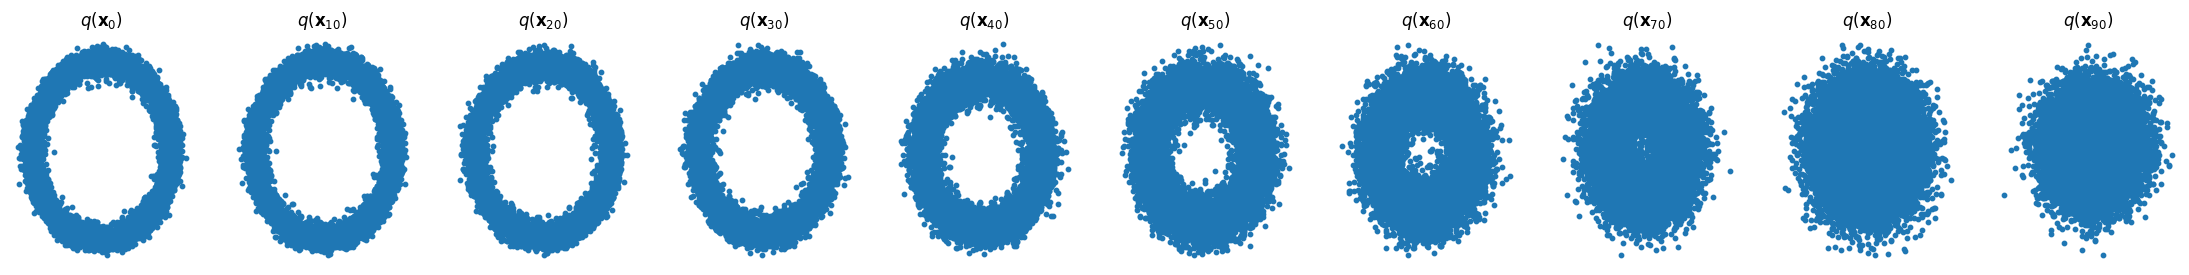

In [24]:
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))

dataset=torch.tensor(sample).cuda()

for i in range(10):
    q_i = q_sample(dataset, torch.tensor([i * 10])).detach().cpu().numpy()
    axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

## 反向去噪过程以及scoring matching
如上述所言，正向加噪过程使用了高斯噪声的逐渐如作为实现，那么去噪过程也是类似的条件高斯过程，则对应的表达式为：
$$
p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}) = \mathcal{N}(\mathbf{x}_{t-1} ; \mathbf{\mu}_{\theta}(\mathbf{x}_{t},t),\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t))
$$
在某些情况下，diffusion model的训练过程可以被看作是一种scoring matching过程。在扩散模型的训练中，模型学习的目标是估计条件分布的分数函数，这与scoring matching的目标相似。在具体的实现步骤方面，扩散模型中的逆向过程需要估计在每一步去噪过程中数据的梯度，这与scoring matching中估计数据分布梯度的目标是一致的。

### DDPM
结合上面介绍的diffusion model整体思路，Ho等人提出了一种数值处理方法，整体思想是改变均值函数以及协方差方程的表达方式，进而，我们得到对应时间下一时间间隔的分布$\mathbf{x}_{t-1}$和对应时间的分布$\mathbf{x}_{t}$之间的关系，其中$\mathbf{\epsilon}_{\theta}$为神经网络的所构建的函数：
$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$

这里的表达式的推导应用了scoring matching以及Lagevin Dynamics，因此表达式和直接使用梯度场推导出的有着相当的相似性。


---

*此后，我们对这一过程进行代码实现并查看其训练效果*

首先，建立合适的神经网络，即上述公式当中的$\mathbf{\epsilon}_{\theta}(\mathbf{x}_t,t)$

In [25]:
import torch.nn.functional as F
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

## 在此基础之上构建损失函数并简化，得到最终的表达结果为：

## $$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$

In [26]:
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    t = t.cuda()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

## 对采样过程进行函数化表达，在后续的流程当中只需要输入原本的样本以及训练出的神经网络即可得到下一时间间隔的样本分布。

In [27]:
def p_sample(model, x, t):
    t = torch.tensor([t]).cuda()
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

def p_sample_loop(model, shape):
    cur_x = torch.randn(shape).cuda()
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

实现训练过程，并在训练过程中监控损失函数的输出。同时，打印出随着神经网络的训练得到的$\mathbf{\epsilon}_{\theta}(\mathbf{x}_t,t)$在diffusion model的反向去噪过程中的表现结果。

tensor(0.6897, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7497, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5545, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7291, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8634, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8667, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6347, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8130, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7264, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6310, device='cuda:0', grad_fn=<MeanBackward0>)


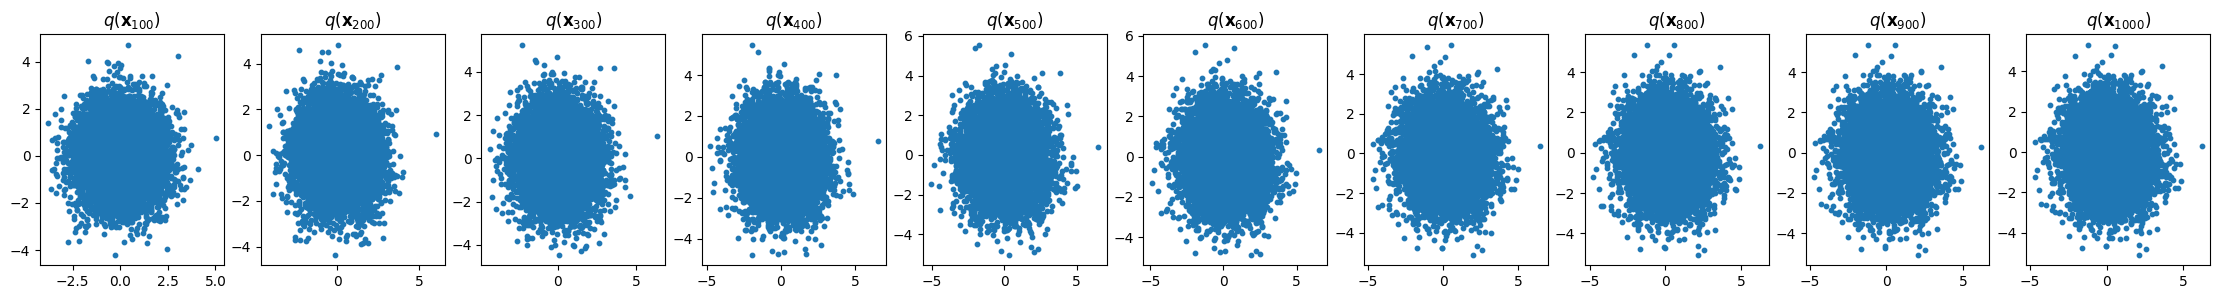

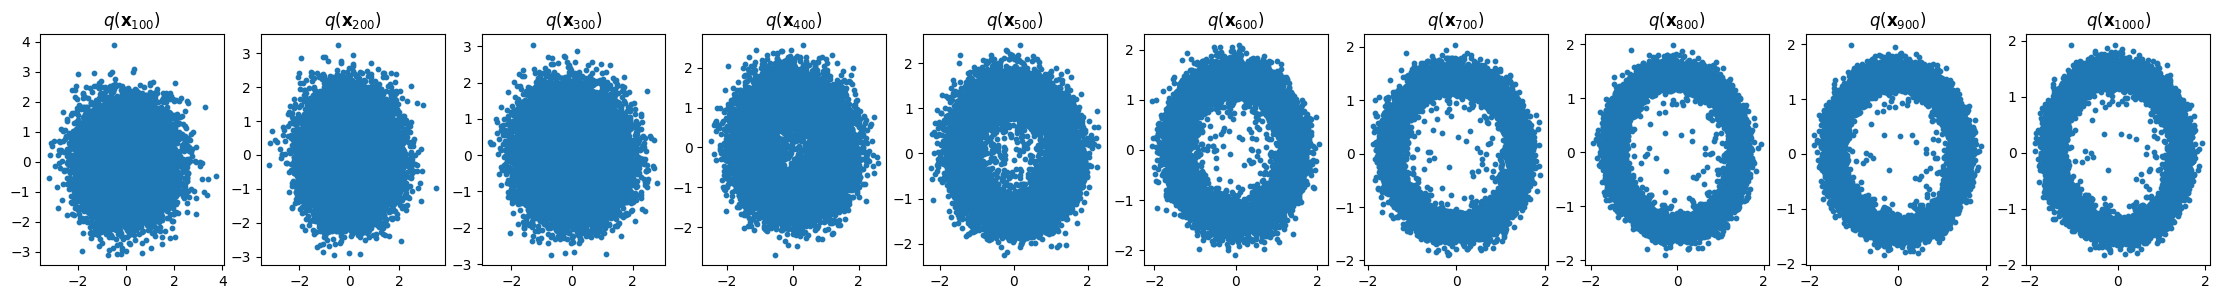

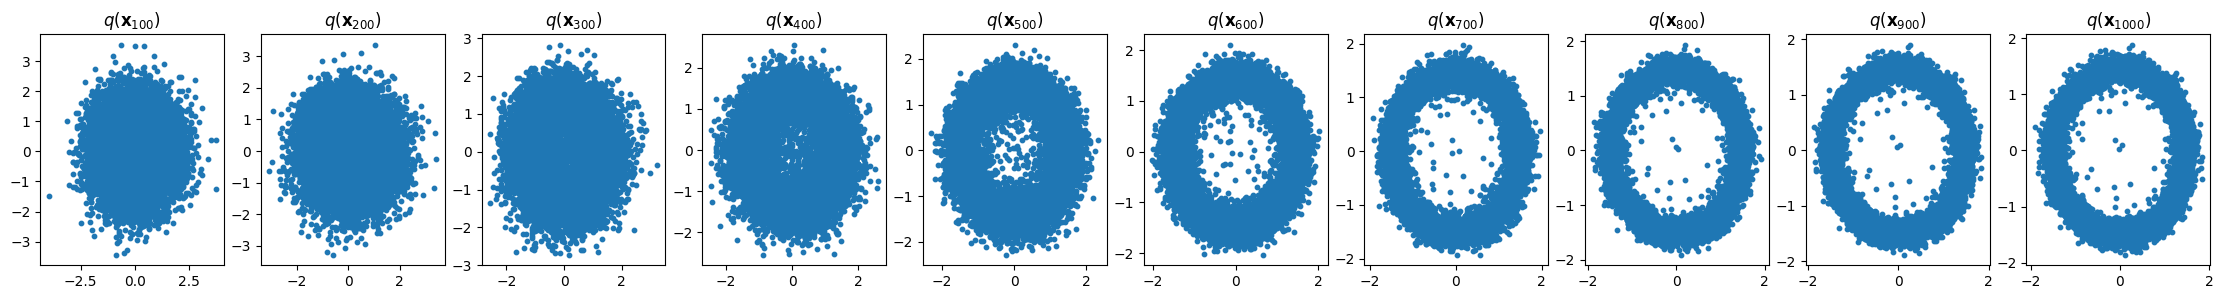

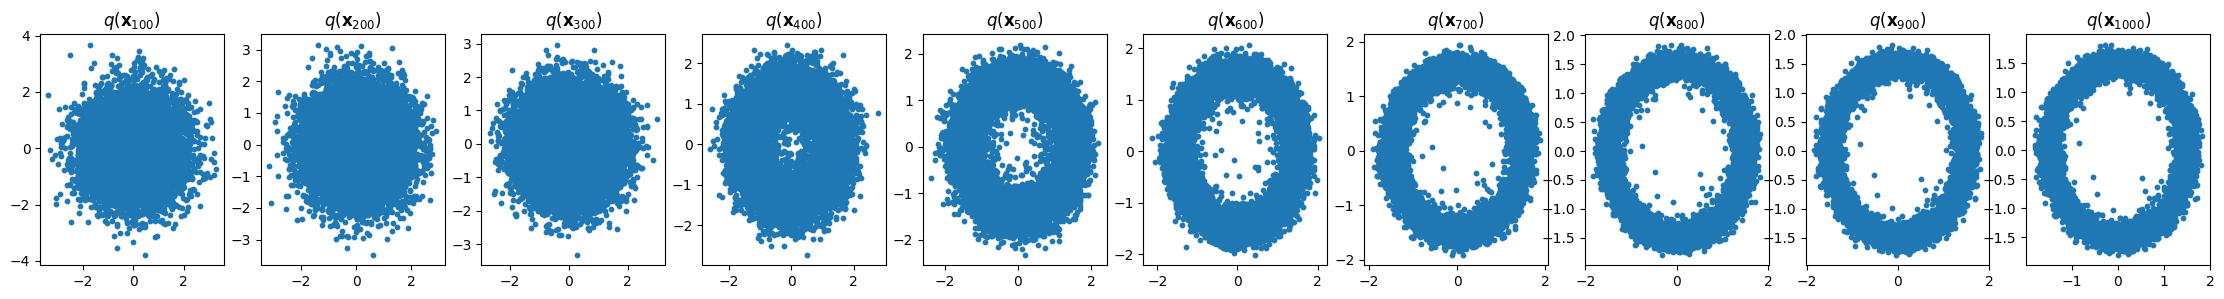

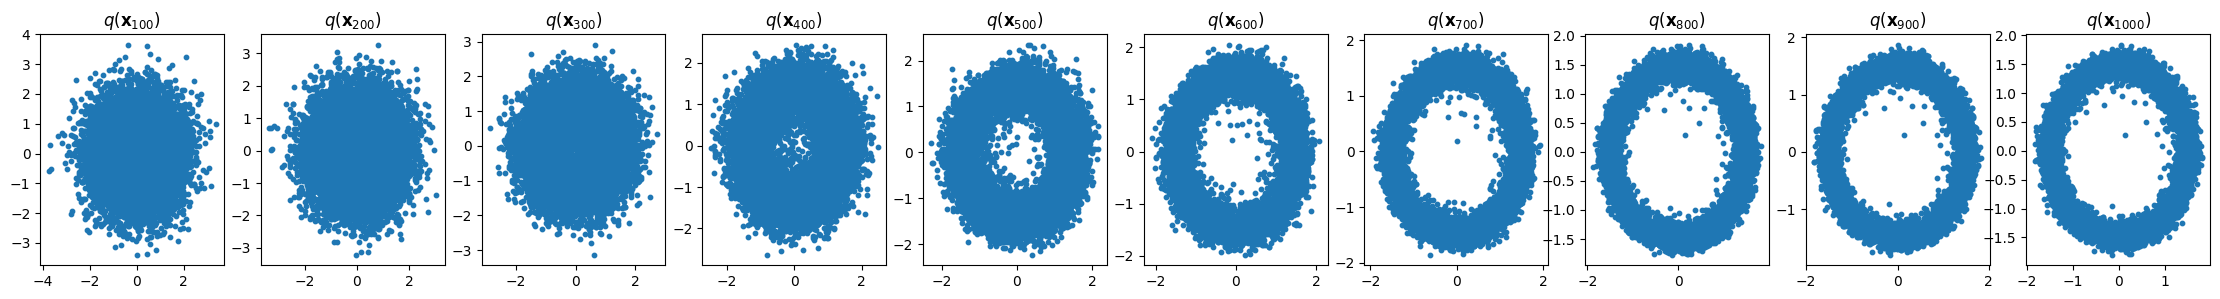

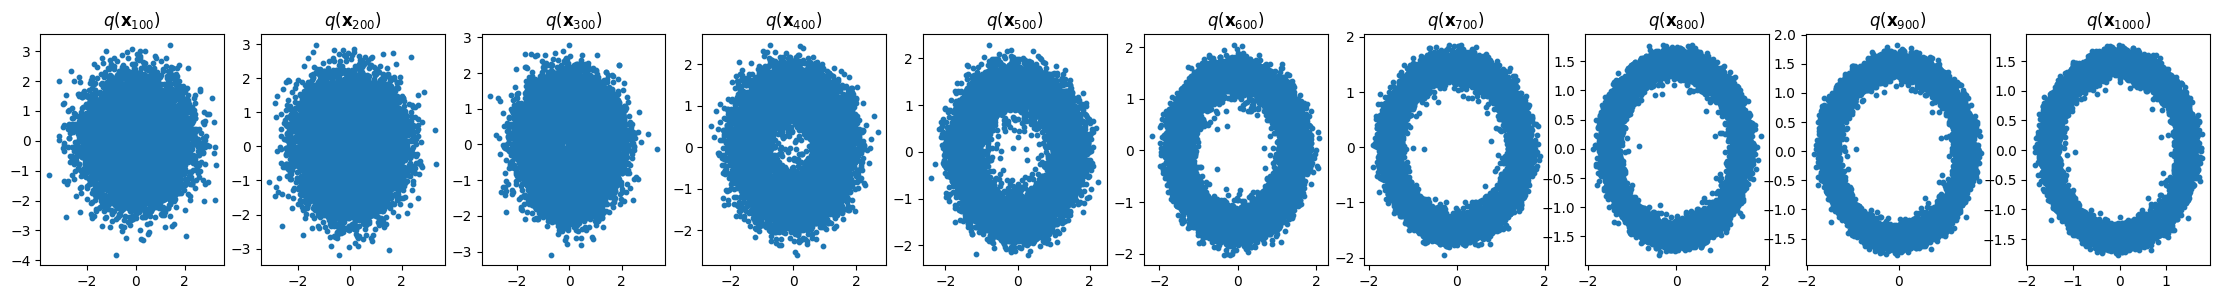

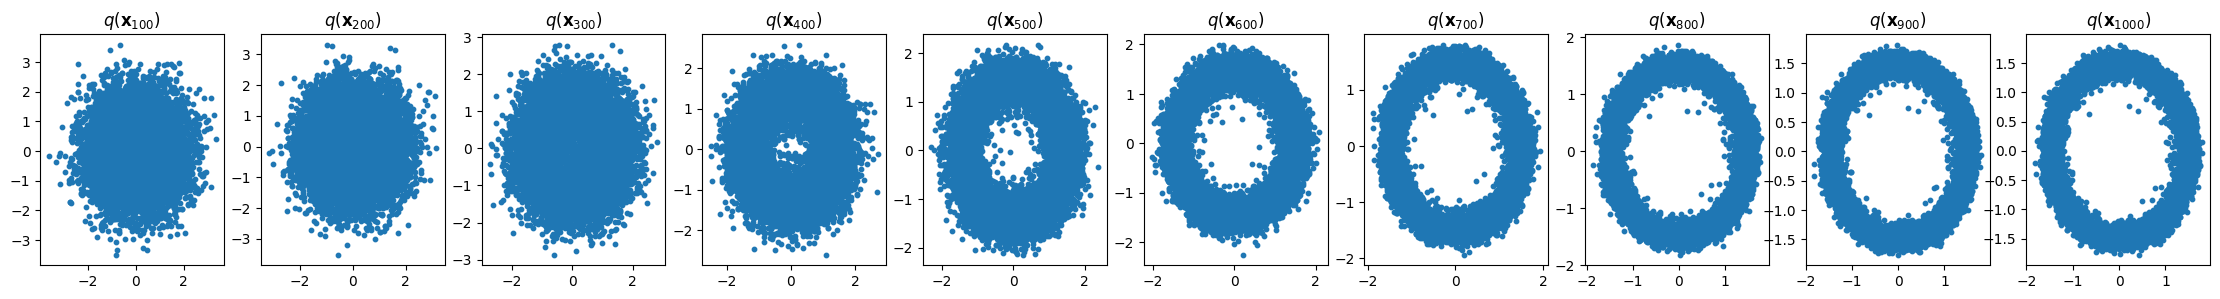

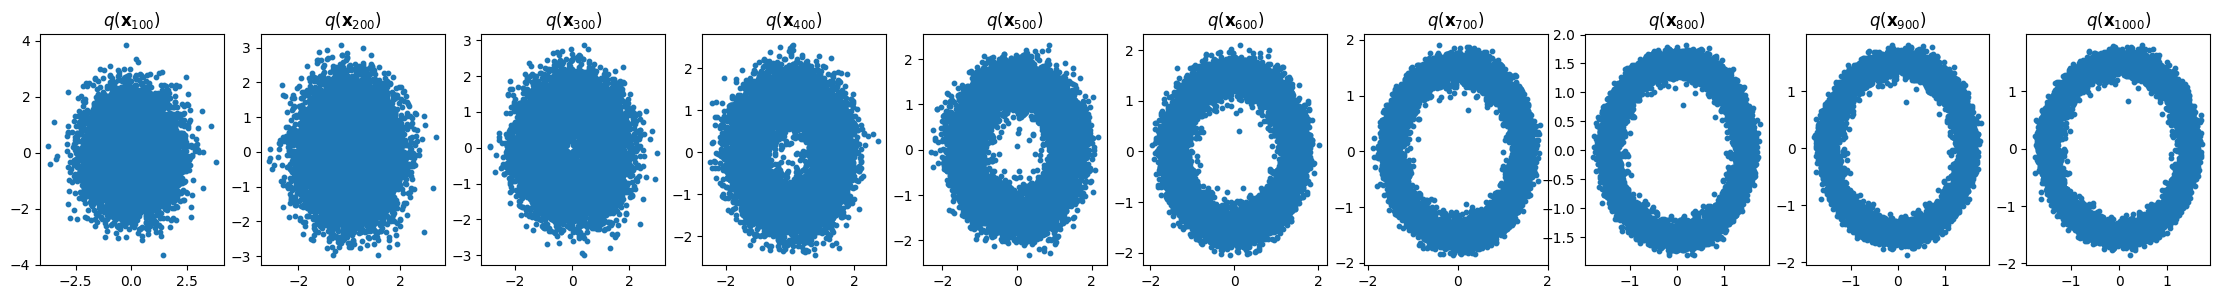

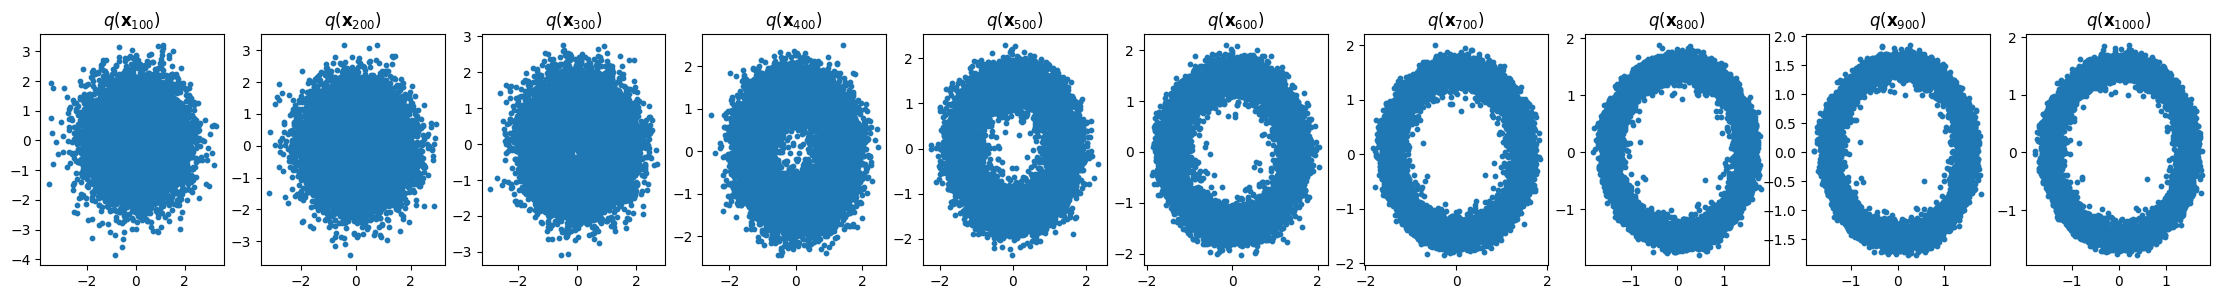

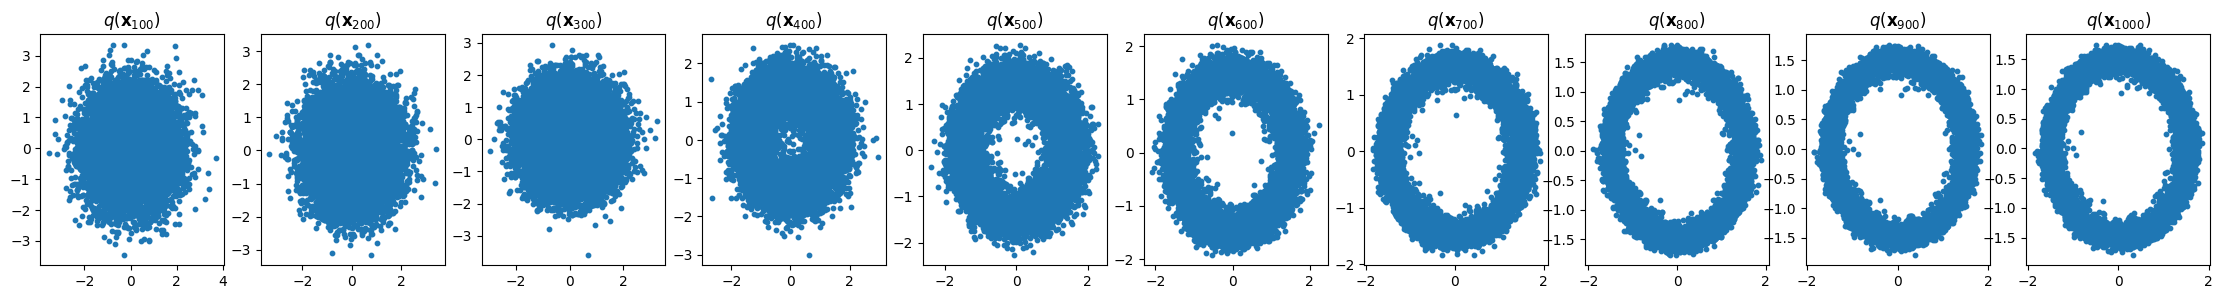

In [28]:
n_steps=100
model = ConditionalModel(n_steps)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(sample).float().cuda()
# Batch size
batch_size = 128
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach().cpu().numpy()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

从结果可以看出，随着神经网络的不断训练，其从高斯分布的散点到我们期待的swiss_roll分布的反响去噪过程的结果越来越接近，说明该神经网络能够做到学习并生成简单的二维分布。

同时，我们测试对称性较高的样本在单纯使用scoring matching和diffusion model的生成效果，发现其在相同的训练步数的条件下，diffusion model具有相对更好的表现，不会出现scoring matching的明显发生和原数据的偏移现象。

### 和scoring matching以及Langevin Dynamic的联系
对于分子模拟的过程来说，我们常常关心使用的力场以及分子在不同状态下的受力情况。而对于上面提到的Diffusion model来说，貌似并没有看到和实际的物理意义相关联的地方，而是单纯的数学处理来使得神经网络更加完善。实际上，对于优化出来的$\epsilon_{\theta}(\mathbf{x}_t,t)$，其和scoring matching中的$\mathbf{s_{\theta}}(\mathbf{x_t})$有着以下的关系：
$$\nabla_{\mathbf{x}}\log p(\mathbf{x}) = \nabla_{\mathbf{x}} \Big(-\frac{1}{2\sigma^2}(\mathbf{x} - \boldsymbol{\mu})^2 \Big) = - \frac{\mathbf{x} - \boldsymbol{\mu}}{\sigma^2} = - \frac{\boldsymbol{\epsilon}}{\sigma}$$
With:
$$q(\mathbf{x}_t \vert \mathbf{x}_0) \sim \mathcal{N}(\sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})$$
We can derive:
$$\mathbf{s}_\theta(\mathbf{x}_t, t) 
\approx \nabla_{\mathbf{x}_t} \log q(\mathbf{x}_t)
= \mathbb{E}_{q(\mathbf{x}_0)} [\nabla_{\mathbf{x}_t} q(\mathbf{x}_t \vert \mathbf{x}_0)]
= \mathbb{E}_{q(\mathbf{x}_0)} \Big[ - \frac{\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)}{\sqrt{1 - \bar{\alpha}_t}} \Big]
= - \frac{\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)}{\sqrt{1 - \bar{\alpha}_t}}$$
有了这样的关系，我们就可以在Langevin Dynamic中对其中的一阶导项进行描述，并对理想分布$p_{\theta}$进行采样。



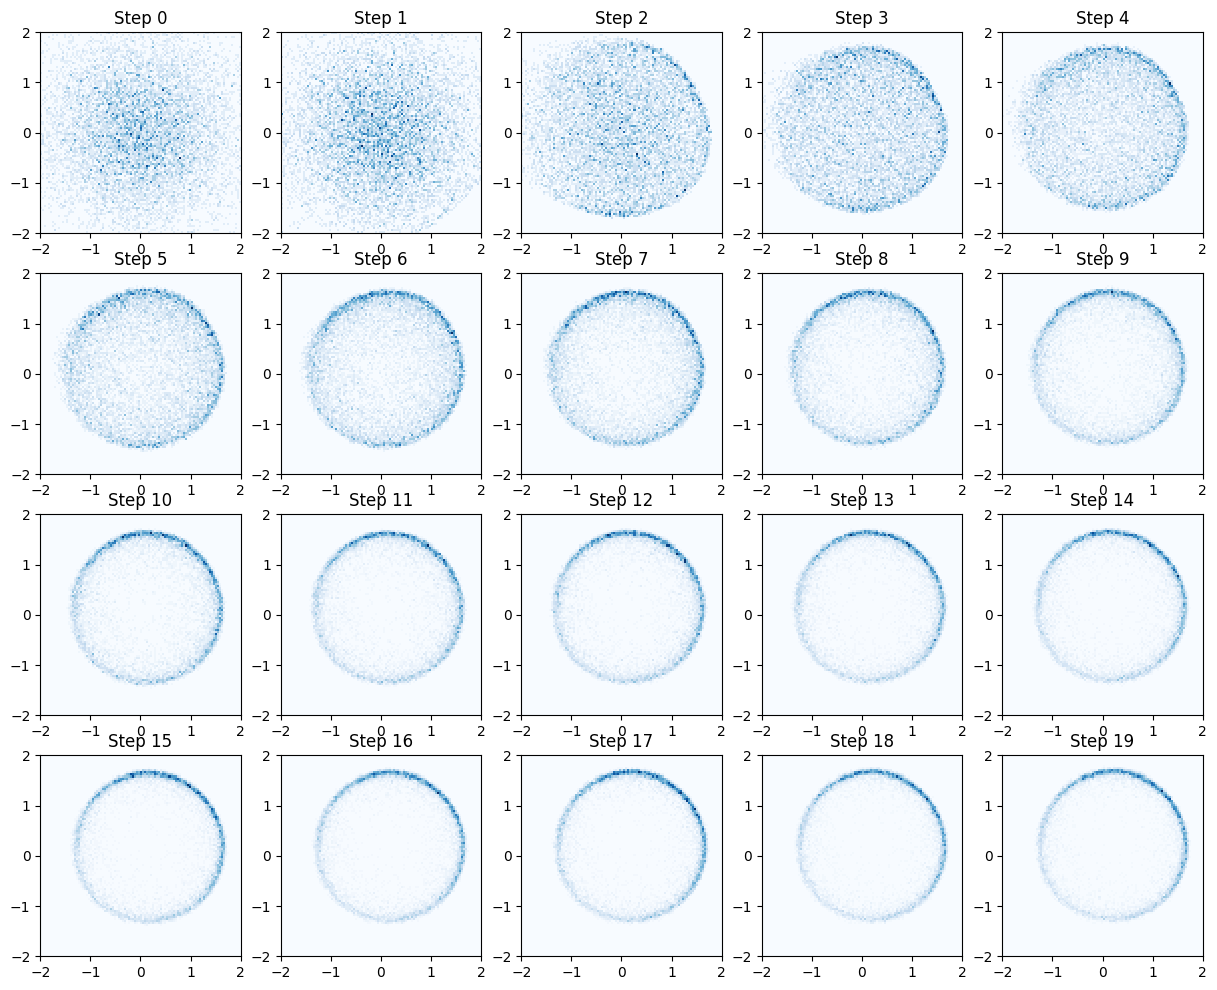

In [30]:
n_steps=19
eps=torch.tensor(1e-2).cuda()
decay=torch.tensor(.9).cuda()
temperature=torch.tensor(1.0).cuda()

xx = torch.normal(0, 1, size=(10**4, 2))
d_xx = torch.sqrt(xx[:,0]**2 + xx[:,1]**2).reshape(-1,1).cuda()
xx_t = []
xx_t.append(xx.detach().numpy())
xx = xx.cuda()

for ii in range(n_steps):
    z_t = torch.rand(xx.size()).cuda()
    xx = xx + -(eps / 2) * model(xx,torch.tensor([ii]).cuda())/extract(one_minus_alphas_bar_sqrt, torch.tensor([ii]).cuda(), xx) + (torch.sqrt(eps) * temperature * z_t)
    # d_xx = torch.sqrt(xx[:,0]**2 + xx[:,1]**2).reshape(-1,1)
    # xx = xx + (eps / 2) * model_psi(xx) + (torch.sqrt(eps) * temperature * z_t)
    eps *= decay
    xx_t.append(xx.detach().cpu().numpy())
xx_t = np.array(xx_t)

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(15, 12))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    # axes[ii_x,ii_y].hist(xx_t[ii,:,0],bins=100, range=np.array([-2, 2.0]))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues',range=np.array([(-2.0, 2.0), (-2.0, 2.0)]))
    axes[ii_x,ii_y].set_xlim([-2,2])
    axes[ii_x,ii_y].set_ylim([-2,2])
plt.show()

## 可以看到，随着时间步数的推进，最终的分布倾向于我们势函数训练所使用的数据集。相较于diffusion model的反向denoising过程，这个过程中的力场是一个更为可衡量的物理量，我们在这个过程中也可以获得更多的信息。

## 值得注意的是，和scoring matching中相同，langevin动力学的结果在第三象限出现了概率偏差，同样不是在圆的均匀分布，这可能是一个值得探究的问题。

# 这跟AI for Science（AI4S）又有什么关系呢？  <a id='layer4'></a>

## 上述讨论跟AI for Science（AI4S）又有什么关系呢？这里就三个方面进行讨论：整体理论、具体技术、类似场景。

## 整体理论
## 从整体理论而言，统计机器学习和统计物理本身就有着极为密切的联系——无论是平衡态的、还是非平衡态的，因此它们往往有着类似的解决方案和难点、也经常可以互相启发。有些时候，熟悉统计物理的同学可能会觉得有很多地方在重复造轮子，例如刘维尔方程似乎被重新发明了很多次；但这也是可以理解的，另一些时候我们则会发现一些地方相互启发很多，尤其是在非平衡热力学中， Jarzynski Equality、Annealed Importance Sampling等都是密切相关的（[这里](https://blog.alexalemi.com/non-equilibrium.html)有篇很好的科普文章），这也启发DeepMind来了篇[Annealed Importance Sampling meets Score Matching](https://openreview.net/forum?id=H43MpnN_vZ9)。


## 当然，在本文作者看来，在统计机器学习中，samples are there；但是在统计物理（及其对应的一系列分子模拟等应用）中，samples need to be sampled in the first place。后者因此会面临更多的问题。

## 具体技术
## 本文介绍的一系列手段都能在分子模拟中找到影子。例如，熟悉分子模拟和统计物理的同学不难看出，score matching中的score本质上和原子体系的受力、或者粗粒化自由度所对应的平均力（mean force）是相对应的。甚至在粗粒化模型的构建过程中，人们也经常采用类似技巧（拟合受力），但不同于score matching，这里面的受力是可以作为label给出的。有趣的是，计算mean force的restrained formulation与上面介绍的DSM中噪音加的大小面临的问题很类似。在restrained formulation，restrain强度过高会带来数值问题、restrain强度过低又难以对体系进行有效控制。具体可参考[DeePCG](https://arxiv.org/abs/1802.08549)和[RiD](https://arxiv.org/abs/1712.03461)两篇文章。

## 跳出来看，就consistency model本身而言，有太多AI4S需要考虑的模型某种意义上也算是“consistency model”了，例如电子结构模型、有限元模型等。这里consistency distillation蒸馏出更高效方案的思路也值得借鉴。

## 类似场景

## 类似场景很多，主要还是因为有太多生成类或者优化类的任务。总体来说，GPT里面的三个字，Generative（生成型任务）、Pre-trained（预训练策略）、Transformer（统一模型框架）在科学领域也有很多的应用。这里篇幅所限，只给出两个：

## 1. 深势科技的[Uni-Mol](https://mp.weixin.qq.com/s/k_Srj-pGIpS61ketHHjkZQ)系列：[Uni-Mol: A Universal 3D Molecular Representation Learning Framework](https://chemrxiv.org/engage/chemrxiv/article-details/6402990d37e01856dc1d1581); [Highly Accurate Quantum Chemical Property Prediction with Uni-Mol+](https://arxiv.org/abs/2303.16982)

## 2. DeepMind在催化结构弛豫方面的工作：[Learned Force Fields Are Ready For Ground State Catalyst Discovery](https://arxiv.org/pdf/2209.12466.pdf)